In [1]:
# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# numpy to calculate RMS with np.std()
import numpy as np

# pandas used for handling the large amounts of data in dataframes rather than python lists
import pandas as pd

# scipy for curve fitting
from scipy.optimize import curve_fit

In [60]:
# Function parameters that are repeated throughout this program are given a '_f' as a suffix. This is to avoid incorrectly 
# overwriting variables.

def theoryFunction(t_f):
    '''
    Returns the theoretical RMS for electron cloud drifting in LAr based on given arrival time(s). 

    Parameters
    ----------
        t_f : array of float or float
            Array of Mean_TOA(s) for each pixel.

    Returns
    -------
        array of float or float: 
            Array of expected RMS' corresponding to the TOA in parameter: t.
    '''
    
    D = 682.23 # mm^2/s
    v = 1.648 * 10**6 # mm/s
    RMS = ((2*(t_f)*D/v**2)**(1/2))
    return RMS

def sqrtFunc(x_f, a_f):
    '''
    Returns the value a*sqrt(x) for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        a_f : float
            Scaling factor of the sqrt function.

    Returns
    -------
        array of float or float: 
            Value(s) equal to a*sqrt(x) corresponding to the array parameter x.
    '''
    return a_f*(x_f)**(1/2)

def fitLine(function, x_f, y_f):
    '''
    Returns fitting parameters, dependent on type of fitted line, for a given dataset. 

    Parameters
    ----------
        function : Function
            General mathematical function returning the dependent y-value for a given independent x-value.
        x_f : array of float
            Independent variables corresponding to the y-array.
        y_f : array of float
            Dependent variables corresponding to the x-array.

    Returns
    -------
        array of float: 
            Array of fitting parameters for each needed parameter in function.
    '''
    params, _ = curve_fit(function, x_f, y_f)
    return params

def gaussFunc(x_f, A_f, x0_f, sigma_f):
    '''
    Returns the dependent value on a Gaussian curve for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        A_f : float
            Amplitude of the Gaussian curve.
        x0_f : float
            Mean value for the Gaussian distribution.
        sigma_f : float
            Standard Deviation for the Gaussian distribution.

    Returns
    -------
        array of float or float: 
            Dependent value on a Gaussian curve corresponding to the array parameter x.
    '''
    return A_f * np.exp(-(x_f - x0_f) ** 2 / (2 * sigma_f ** 2))

def gaussFitHist(data_f, binNum_f):
    '''
    Takes in a histogram and returns the gaussian fitting parameters for the histogram as well as the points used for fitting. 

    Parameters
    ----------
        data_f : array of float
            Array of values used in histogram distribution.
        binNum_f : int
            Number of bins used in histogram plot.

    Returns
    -------
        gauss_params : array of float or float 
            Fitting parameters used to generate a Gaussian curve fitted to histogram bars.
        gaussDataPoints : DataFrame
            DataFrame filled with xvalues and yvalues of the points in the center and on top of each histogram bar.
    '''
    counts, bins = np.histogram(data_f, bins = binNum_f)
    binCenters = []
    
    for i in range(len(bins) - 1):
        binCenters.append((bins[i]+bins[i+1])/2)

    gaussDataPoints = pd.DataFrame(data={'xvalues': binCenters, 'yvalues': counts
                                        })
                                                   
    gauss_params, _ = curve_fit(gaussFunc, gaussDataPoints["xvalues"], gaussDataPoints["yvalues"],
                                p0 = [gaussDataPoints["yvalues"].max(), data_f.mean(), data_f.std()])
    
    return gauss_params, gaussDataPoints

def getBinNum(binNum_f, maxVal0_f, minVal0_f, maxVal_new_f, minVal_new_f):
    '''
    Returns a bin number, proportional to the original bin number, for a subset of data. 

    Parameters
    ----------
        binNum_f : int
            Original number of bins used in histogram plot.
        maxVal0_f : float
            Max value on the histogram when binning using binNum.
        minVal0_f : float
            Min value on the histogram when binning using binNum.
        maxVal_new_f : float
            Max value on the histogram for the subset of data.
        minVal_new_f : float
            Min value on the histogram for the subset of data.

    Returns
    -------
        newBinNum : int
            Bin number used for the subset of data that will maintain the midth of the original bins.
    '''
    newBinNum = abs(int(binNum_f * (maxVal_new_f - minVal_new_f)/(maxVal0_f - minVal0_f)))
    if newBinNum == 0:
        return 1
    else:
        return newBinNum
        
def getZValues(dataFrame_f):
    '''
    Returns the Z-position for pixels in an event with a calculated t0. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 't0'.

    Returns
    -------
        dataFrame_f["Z_Position"] : array
            Array containing the expected Z-position based on the electron drift velocity and a calculated t0 for the event.
    '''
    v0 = 1.648 * 10**6 # mm/s
    
    dataFrame_f["Z_Position"] = (dataFrame_f["mean_TOA"] - dataFrame_f["t0"])*v0
    return dataFrame_f["Z_Position"]

def bestFitRemoveOutliers(dataframe_f, minStDev_indices, contribution_lim, cutoff= 3):
    '''
    Iterative scheme to get the best functional form fit for the dataset while removing outliers.    

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS'.
        minStDev_indices : array-like
            Array containing the indices of the pixel with the min_deltaStDev for each event.
        contribution_lim : int
            Limit determining the contribution of Chi^2 to be considered an outlier.
        cutoff : int, default 3
            Cutoff for number of iterations. More than 3 iterations will lose good pixels.         
            
    Returns
    -------
        best_fit : float
            Best fitting parameter for the sqrtFunc after removing outlier contribution.
    '''
    # dataframe_f is the full dataframe. We want to work with the minStDev for each event.
    # Start by defining a smaller dataframe consisting of the smallest StDev for each event
    df = dataframe_f.loc[minStDev_indices]
    # Initialize array to hold fit history
    fit_history = []
    # Initialize loop breaker, avoiding infinite loop
    counter = 0
    # Fit the smallest StDev pixels with a sqrt curve
    fit_history.append(fitLine(sqrtFunc, df["mean_TOA"], df["RMS"])[0])
    
    # Loop is to run until we get the same fit repeated.
    # Boolean flag initially set to False as it will later take boolean value whether the new fit and previous fit
    # are the same.
    flag = False   
    while not flag:
        
        # Counter += 1 for every iteration
        counter += 1
        # Store newest fit in old fit variable
        best_fit = fit_history[-1]
        
        # Calculate the expected_RMS and delta_StDev for values in list
        df["Expected_RMS"] = sqrtFunc(df["mean_TOA"], best_fit)
        df["delta_StDev"] = df["RMS"] - df["Expected_RMS"]
    
        df["Event_Outlier"] = defineOutliers(df, contribution_lim)
        
        # Get new fit excluding outliers
        fit_history.append(fitLine(sqrtFunc, df[df["Event_Outlier"] == False]["mean_TOA"], 
                                             df[df["Event_Outlier"] == False]["RMS"])[0])
        
        # Check whether the new fit is same as old
        flag = (best_fit == fit_history[-1])
    
        if counter == cutoff:
            print("Reached max number of iterations: %d" %cutoff)
            flag = True
    
    print("Fit returned after %d iterations." %counter)
    return df["Event_Outlier"], best_fit, fit_history

def defineOutliers(dataframe, contribution_lim):
    '''
    Iterative scheme to record each outlier to remove from functional fit.
    
    This scheme finds the pixel with the largest Chi^2 contribution. If this pixel is not a previously defined outlier, 
    and the contribution is >= contribution_lim, the pixel is recorded as an outlier. Each time a new outlier is recorded, 
    the mean_deltaSTDev and RMS_delta_StDev for the set is recalculated (ignoring the outlier), and the process is repeated.
    The loop continues until an outlier is not recorded on a given iteration.

    Parameters
    ----------
        dataFrame : DataFrame
            DataFrame of smallest StDev pixels for each event, with columns (at least): 'mean_TOA', 'RMS', ''.
        contribution_lim : int
            Limit determining the contribution of Chi^2 to be considered an outlier.    
            
    Returns
    -------
        df_copy["Event_Outlier"] : DataFrame column
            DataFrame with one column 'Event_Outlier' containing boolean values:
                True: Pixel's delta_StDev is outside numSigma sigma from mean
                False: Pixel's delta_StDev is within numSigma sigma from mean
                NaN: Pixel is not the minimum StDev for the given event, hence it is not considered for outliers.
    '''
    # Create copy of dataframe
    df_copy = dataframe.copy()
    df_copy.loc[:, "Event_Outlier"] = False
    # Define boolean flag change
    change = True
    
    while change:
        # Find the delta_StDev RMS and mean of non-outlier events
        mu = df_copy[df_copy["Event_Outlier"] == False]["delta_StDev"].mean()
        sigma = df_copy[df_copy["Event_Outlier"] == False]["delta_StDev"].std()
        
        # Calculate Chi2 for all pixels
        df_copy["Chi2_Value"] =  (mu - df_copy["delta_StDev"])**2 / sigma**2
        
        # Find the index of the pixel that is not already an outlier and has max Chi2 value
        maxChi_id = df_copy[df_copy["Event_Outlier"] == False]["Chi2_Value"].idxmax()
        
        # If the max Chi2 from non-outliers is >= contribution_lim, define the pixel as outlier and repeat loop
        # else, no more outliers need to be defined, so we have "removed" all the outliers. 
        if df_copy.loc[maxChi_id, "Chi2_Value"] >= contribution_lim:
            df_copy.loc[maxChi_id, "Event_Outlier"] = True
        else:
            change = False
    
    return df_copy["Event_Outlier"]

def ToAShift_Index(dataframe_f, event_num_f, functionalForm_f):
    '''
    WIP

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS', 'expected_RMS', 'delta_StDev'.
        event_num_f : int
            Event number for the event we are finding t0 for.
        functionalForm_f : float
            Parameter for the sqrtFunc to fit the pixels with the smallest StDev for each event.

    Returns
    -------
        pixel_id : int
            Index of the pixel with the smallest delta_StDev after ToA shifting.
    '''
    # This function will be used in a for loop for all events.
    # Get subset of dataframe consisting of rows with event = event_num_f
    event_df = dataframe_f[dataframe_f["event"] == event_num_f].copy().reset_index(drop = False)
    
    # Get the smallest StDev in the dataframe and shift it's time such that it resides on functional fit
    minRMS_index = event_df["RMS"].idxmin()
    expected_TOA = (event_df["RMS"].min()/functionalForm_f)**2
    delta_t = event_df.iloc[minRMS_index]["mean_TOA"] - expected_TOA
    
    # Shift all pixels by the calculated delta_t
    event_df["mean_TOA"] = event_df["mean_TOA"] - delta_t
    
    # In very rare case delta_t might originally be 0, still force the loop to occur
    if delta_t == 0:
        delta_t = float('inf')
    
    while delta_t != 0:
        
        # Get the expected RMS for a given time and the corresponding delta_StDev
        event_df["Expected_RMS"] = sqrtFunc(event_df["mean_TOA"], functionalForm_f)
        event_df["delta_StDev"] = event_df["RMS"] - event_df["Expected_RMS"]
        
        # Find the smallest delta_StDev and shift it's time such that it resides on functional fit
        min_deltaRMS_index = event_df["delta_StDev"].idxmin()
        expected_TOA = (event_df.iloc[min_deltaRMS_index]["RMS"]/functionalForm_f)**2
        delta_t = event_df.iloc[min_deltaRMS_index]["mean_TOA"] - expected_TOA
        
        # Shift all pixels by the calculated delta_t
        event_df["mean_TOA"] = event_df["mean_TOA"] - delta_t 
        
    pixel_id = event_df.iloc[event_df['delta_StDev'].idxmin()]['index']
    
    return pixel_id

In [61]:
# Introduce Global Variables for event num and file paths/names

directory_path = '/scratch/group/mitchcomp/DUNE/data/Standard/muon_rtd_2023-07-01_152715'
resets_file_name = 'resets_output.txt'
g4_file_name = 'g4_output.txt'

# Define the minimum nResets per pixel to be considered
reset_num = 8

# Define chi squared contribution to be considered an outlier
chiSquared_Lim = 9

# Define bins to be used for distribution plots and Gaussian fits
binNum = 100

# Define total events in sample
total_events = 100

In [62]:
# Open the resets_output.txt file and read into pandas dataframe
resets_df = pd.read_csv(directory_path + '/' + resets_file_name)

# Setting Up the DataFrame

In [63]:
# Group the pixels by event, pixel_x, and pixel_y. This is done by the .groupby() function
    # as_index = False gives each pixel a unique row, rather than a set of rows for a unique pixel_x.
    
# For each grouping, calculate the count, mean, and std of the column: 'reset_time'. This is done by the .agg() function
    
# .droplevel(0, axis = 1) drops the top level of column names (which was event, pixel_x, and pixel_y) created by .agg()
pixel_resets = resets_df.groupby(['event','pixel_x','pixel_y'], as_index = False).agg({'reset_time':['count','mean','std']}).droplevel(0, axis = 1)

# Rename the columns
pixel_resets.columns = ['event', 'pixel_x', 'pixel_y', 'nResets', 'mean_TOA', 'RMS']

# Create the main_df that only consists of pixels with nResets >= reset_num
    # .reset_index() will make the first row index = 0 rather than the index that row had in pixel_resets
main_df = pixel_resets[pixel_resets['nResets'] >= reset_num].copy().reset_index(drop = True)

# Finding Functional Fit

In [64]:
# Find the indicies for the min RMS for each event
min_RMS_indices = []
for event_num in range(total_events):
    min_RMS_indices.append(main_df[(main_df["event"] == event_num)]["RMS"].idxmin())

In [65]:
# Get initial fit of smallest RMS for each event
initial_fit = fitLine(sqrtFunc, main_df.iloc[min_RMS_indices]['mean_TOA'], main_df.iloc[min_RMS_indices]['RMS'])[0]

### TOA Shifting

In [66]:
# Get new list of indices for smallest delta_StDev
min_deltaRMS_indices = []
for event_num in range(total_events):
    min_deltaRMS_indices.append(ToAShift_Index(main_df, event_num, initial_fit))

In [67]:
# Create list of event numbers that were changed after ToA shifting (a new pixel is being fitted with the functional form).
changed =[]
for i in range(0, len(min_RMS_indices)):
    if min_RMS_indices[i] != min_deltaRMS_indices[i]:
        changed.append(i)
changed

[17, 18, 57, 73, 74, 79, 81, 89]

### Remove Outliers

In [68]:
# Get the best fit from the data by iterating and removing outliers
main_df["Event_Outlier"], functionalForm, fit_history = bestFitRemoveOutliers(main_df, min_deltaRMS_indices, chiSquared_Lim)
print('Functional Form: %5E * sqrt(mean_TOA)' %functionalForm)

Fit returned after 2 iterations.
Functional Form: 1.963596E-05 * sqrt(mean_TOA)


## Plot Results

In [69]:
D = 682.23 # mm^2/s
v = 1.648 * 10**6 # mm/s
theory_coeff = ((2*D/v**2)**(1/2))

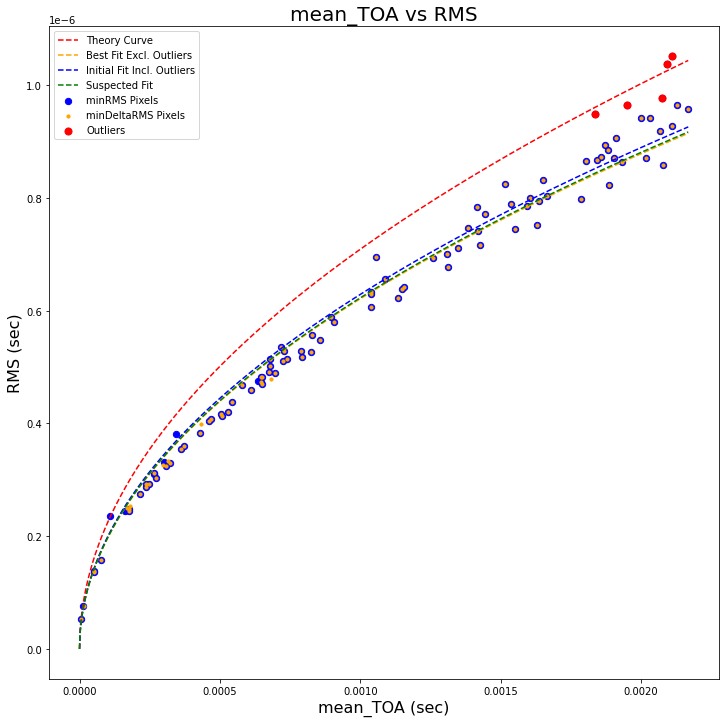

Theoretical Fit (red): 			2.241E-05
Initial Fit Incl. Outliers (blue): 	1.988E-05
Best Fit Excl. Outliers (orange): 	1.964E-05
Suspected Fit (green): 			1.969E-05


In [70]:
plt.figure(figsize = (12, 12))
plt.scatter(main_df.iloc[min_RMS_indices]["mean_TOA"], main_df.iloc[min_RMS_indices]["RMS"], s = 40, color = 'blue', label='minRMS Pixels')
plt.scatter(main_df.iloc[min_deltaRMS_indices]["mean_TOA"], main_df.iloc[min_deltaRMS_indices]["RMS"], s = 10, color = 'orange', label='minDeltaRMS Pixels')
plt.scatter(main_df[main_df["Event_Outlier"] == True]["mean_TOA"], main_df[main_df["Event_Outlier"] == True]["RMS"], s = 50, color = 'Red', label='Outliers')

x = np.linspace(0, main_df.iloc[min_deltaRMS_indices]["mean_TOA"].max(), 1000)
y_initial = sqrtFunc(x, fit_history[0])
y_final = sqrtFunc(x, functionalForm)
y_expected = sqrtFunc(x, 1.969*10**(-5))
y_theory = theoryFunction(x)

plt.plot(x, y_theory, '--', color = 'red', label = 'Theory Curve')
plt.plot(x, y_final, '--', color = 'orange', label = 'Best Fit Excl. Outliers')
plt.plot(x, y_initial, '--', color = 'blue', label = 'Initial Fit Incl. Outliers')
plt.plot(x, y_expected, '--', color = 'green', label = 'Suspected Fit')

plt.title('mean_TOA vs RMS', fontsize = 20)
plt.xlabel('mean_TOA (sec)', fontsize = 16)
plt.ylabel('RMS (sec)', fontsize = 16)
plt.legend()
plt.show()

print('Theoretical Fit (red): \t\t\t%.3E' %theory_coeff)
print('Initial Fit Incl. Outliers (blue): \t%.3E' %fit_history[0])
print('Best Fit Excl. Outliers (orange): \t%.3E' %functionalForm)
print('Suspected Fit (green): \t\t\t1.969E-05')

Gaussian Parameters: A: 6.60696E+00, x0: 4.08928E-05, sigma: 4.01976E-05


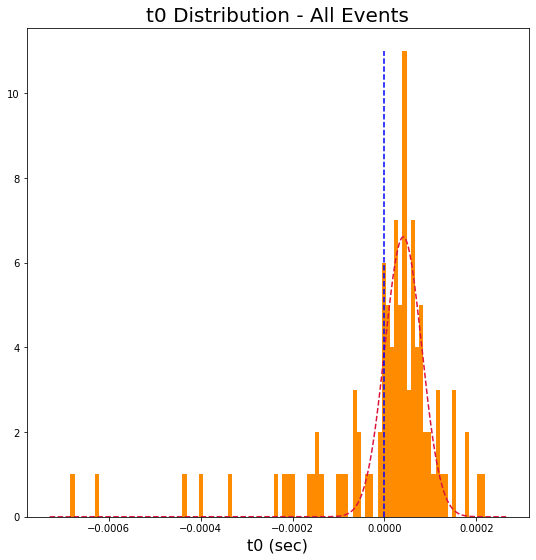

In [129]:
plt.figure(figsize = (9,9))
plt.hist(t0_df["t0"], bins = binNum, color = 'darkorange')

t0_gauss_params, hist_data = gaussFitHist(t0_df["t0"], binNum) 
# Plot the Gaussian Fit
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 1000)
ys = gaussFunc(xs, *t0_gauss_params)
plt.plot(xs, ys, '--', color = 'crimson', label = 'Gaussian Fit')
plt.title('t0 Distribution - All Events', fontsize = 20)
plt.xlabel('t0 (sec)', fontsize = 16)
print('Gaussian Parameters: A: %3.5E, x0: %3.5E, sigma: %3.5E' %(t0_gauss_params[0], t0_gauss_params[1], 
                                                                 t0_gauss_params[2]))
# Plot vertical line at t = 0
x = [0]*2
y = np.linspace(0, hist_data['yvalues'].max(), 2)
plt.plot(x, y, '--', color = 'blue')
plt.show()
plt.close()

# Reconstruct and Compare to G4 data

In [130]:
# Open the g4_output.txt file and read into pandas dataframe

g4_df = pd.read_csv(directory_path + '/' + g4_file_name)

In [132]:
# Add the t0 dataframe as a 't0' column to the main_df by aligning the event numbers
reconstruction_df = main_df.copy().reset_index(drop = True)

# Convert the pixel numbers to a position in mm
reconstruction_df["X_Position"] = reconstruction_df["pixel_x"] * 4
reconstruction_df["Y_Position"] = reconstruction_df["pixel_y"] * 4
reconstruction_df["Z_Position"] = getZValues(reconstruction_df)

In [133]:
# To plot the G4 data quickly, import LineCollection. This avoiding iteratin grows and plotting it that way
from matplotlib.collections import LineCollection

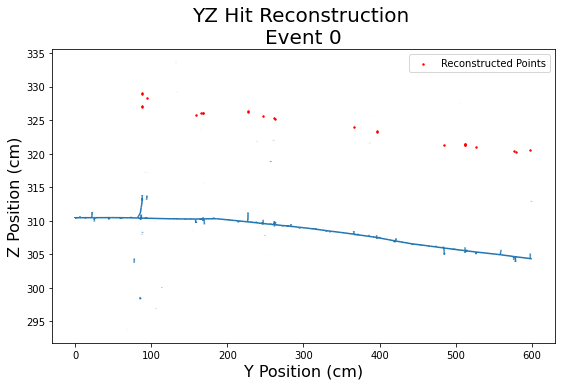

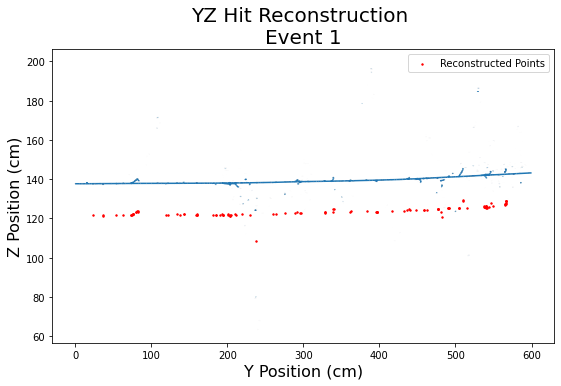

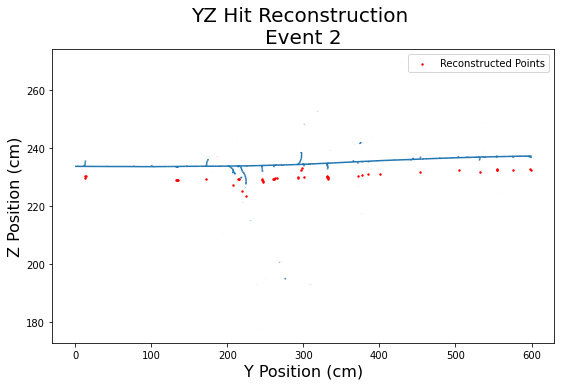

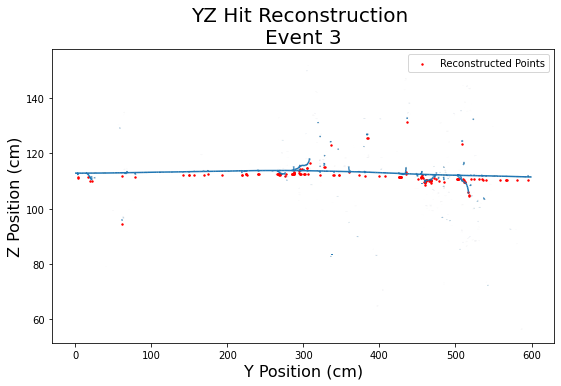

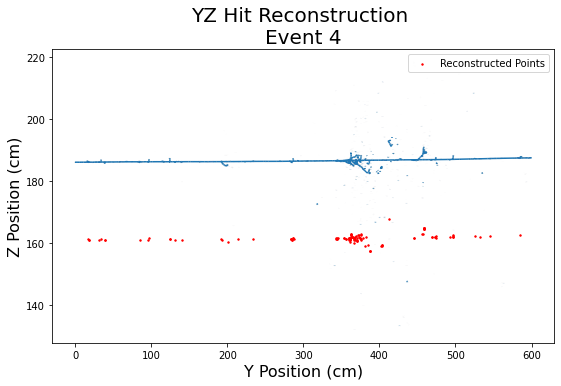

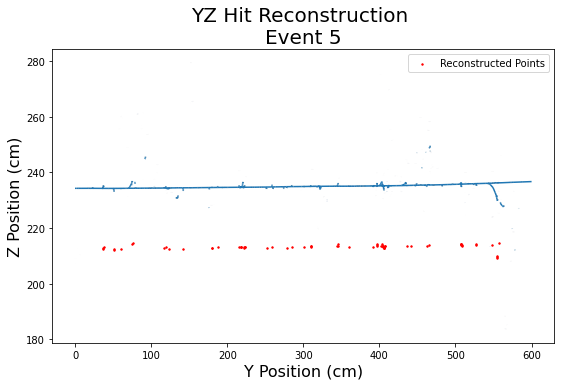

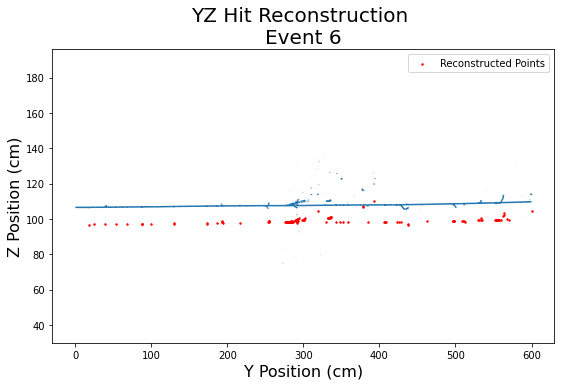

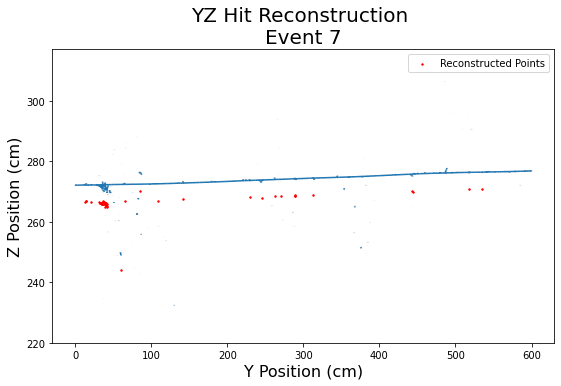

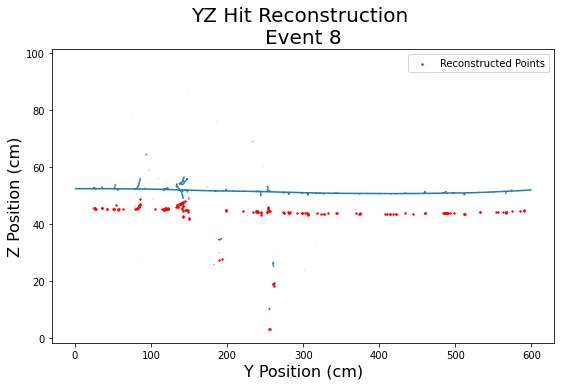

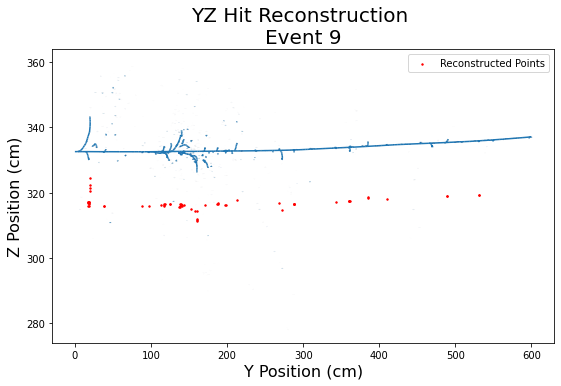

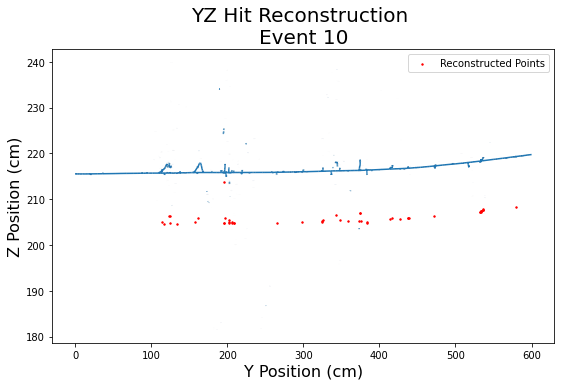

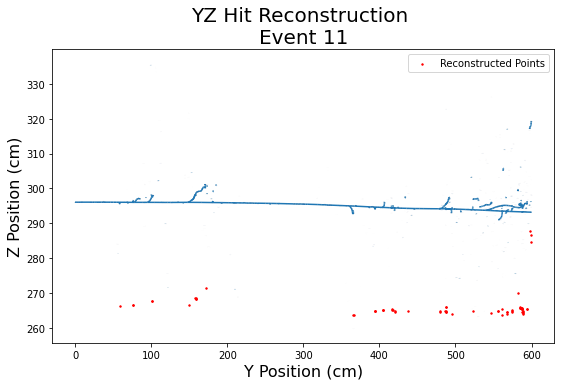

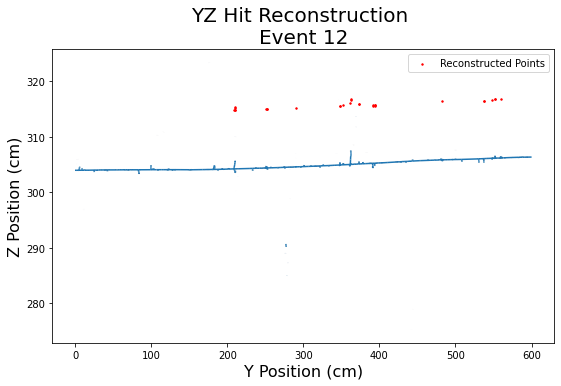

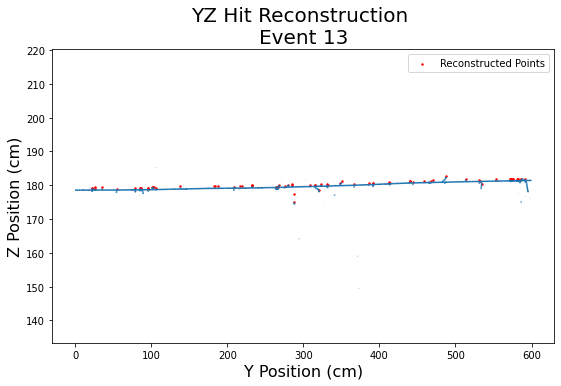

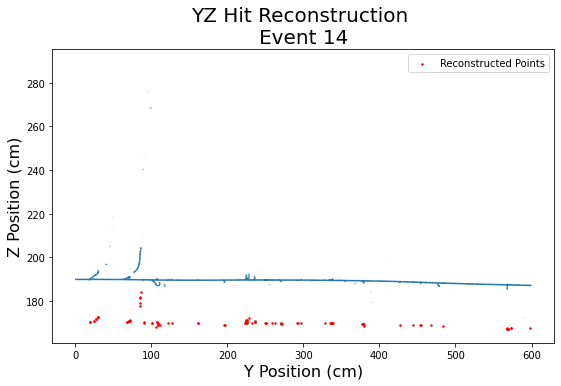

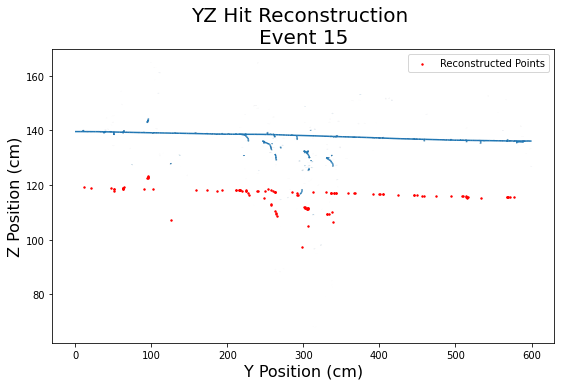

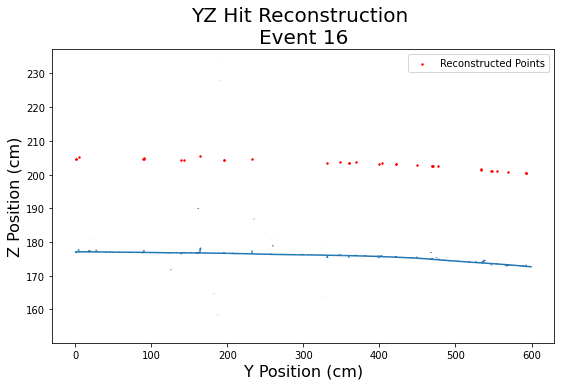

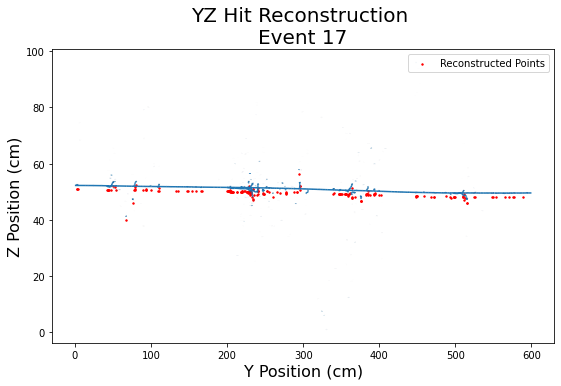

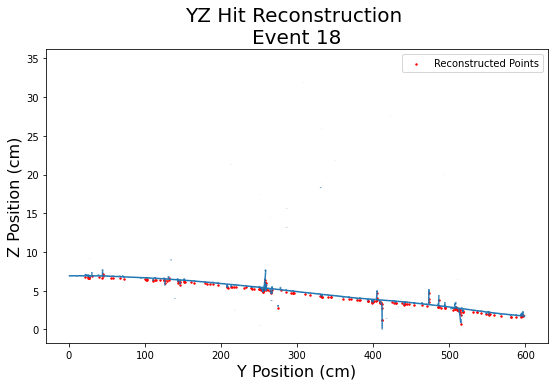

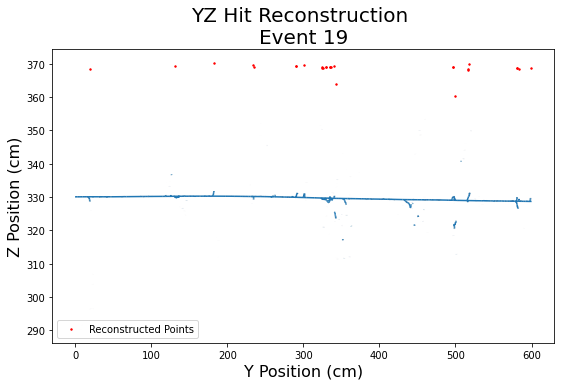

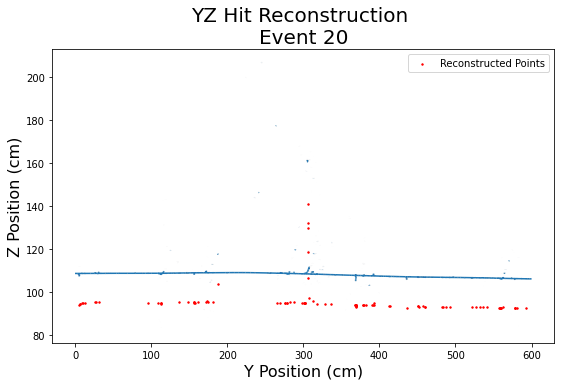

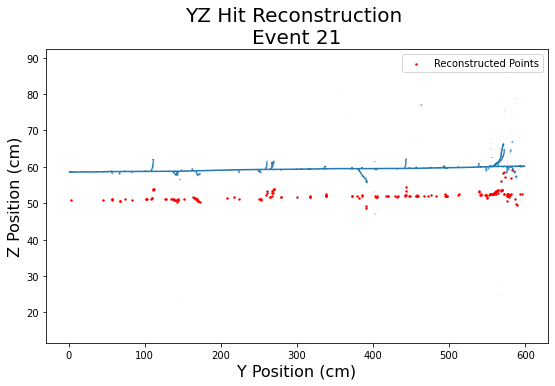

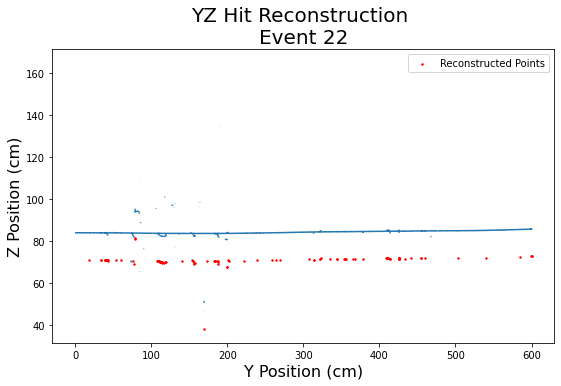

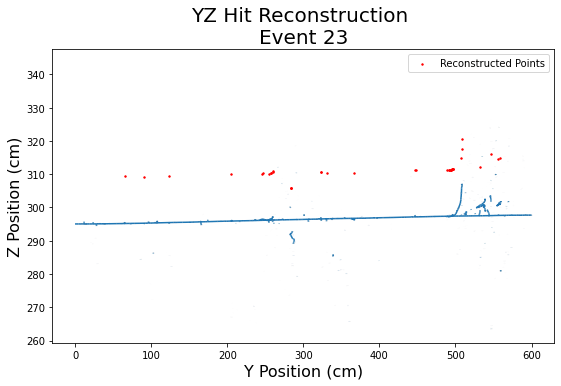

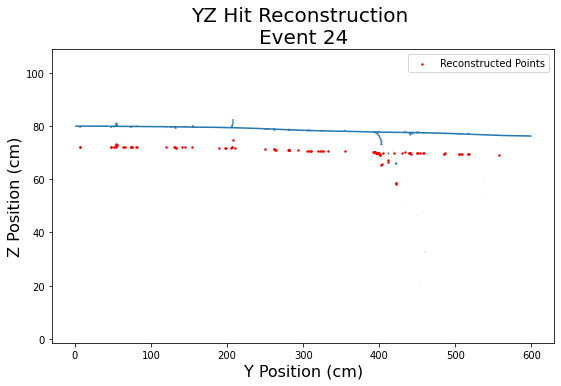

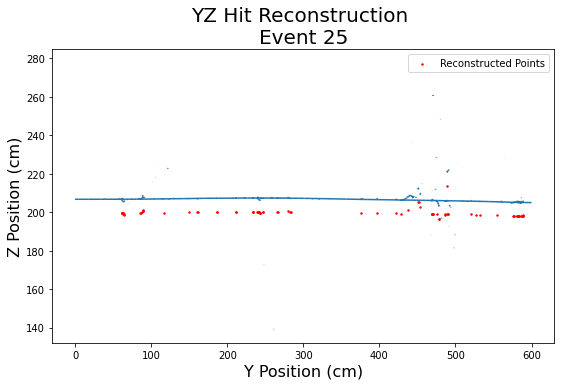

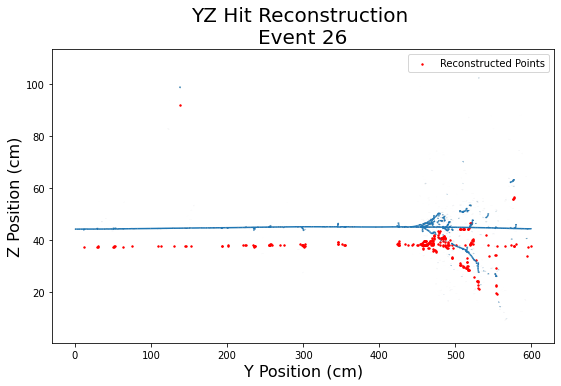

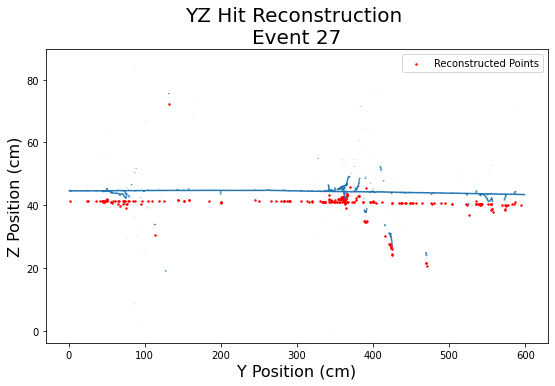

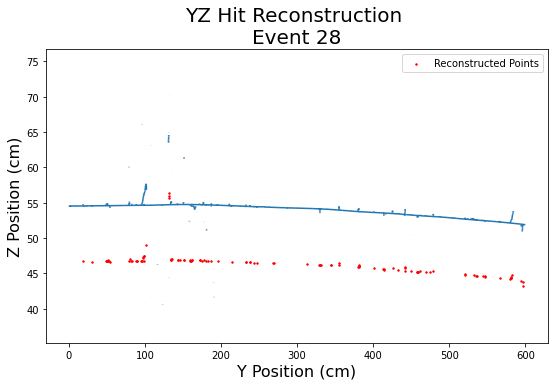

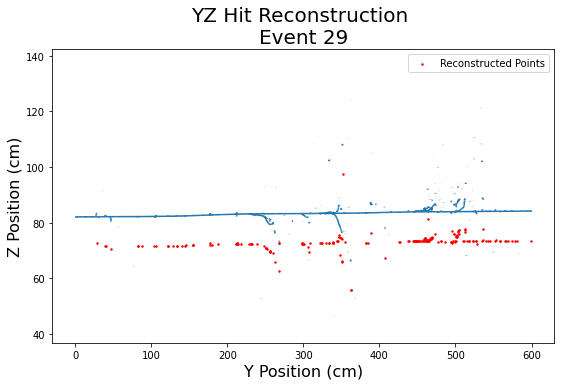

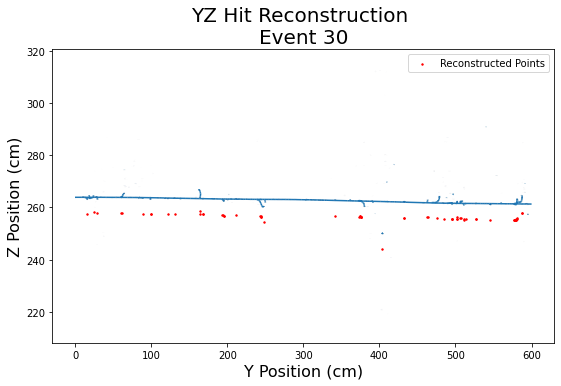

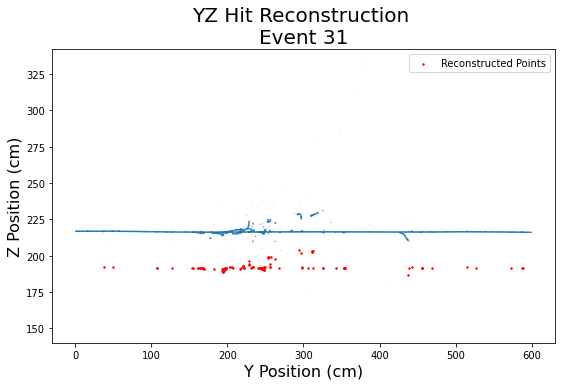

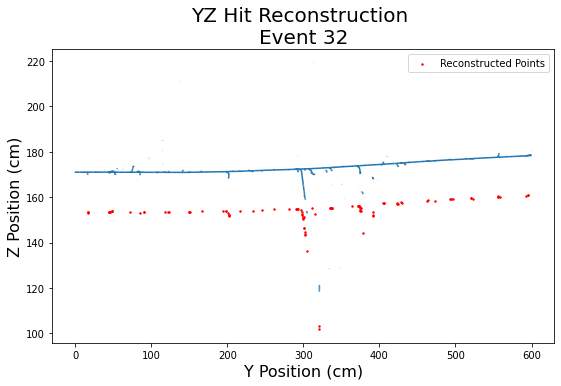

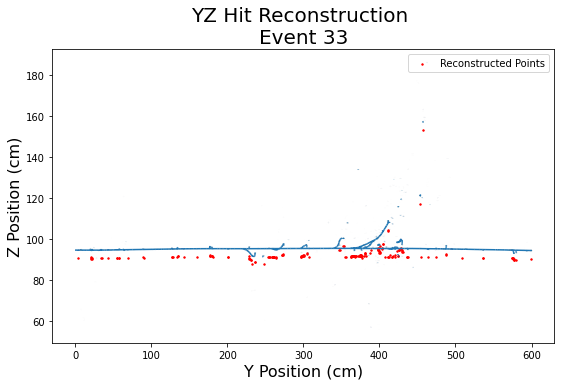

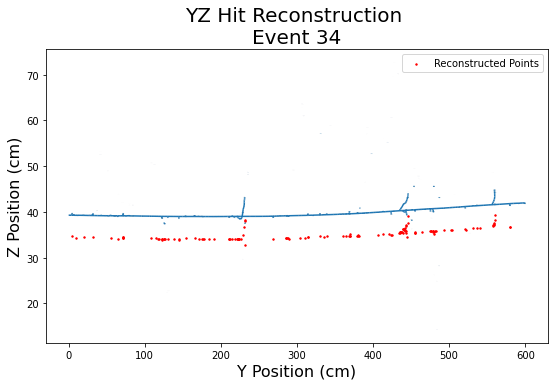

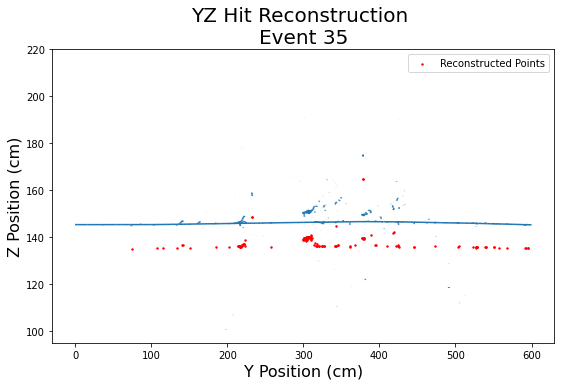

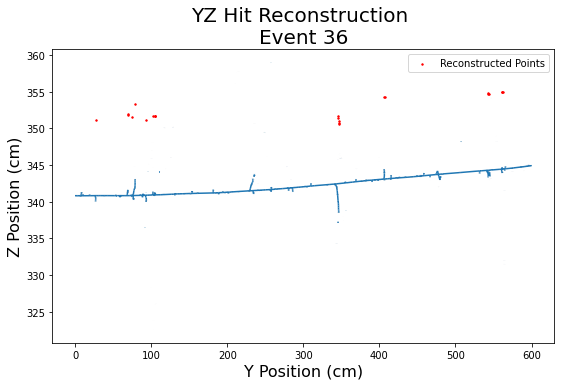

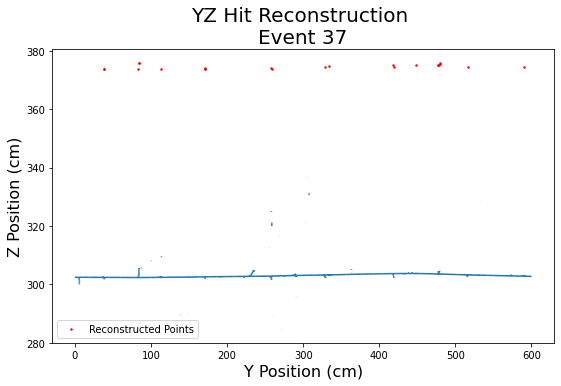

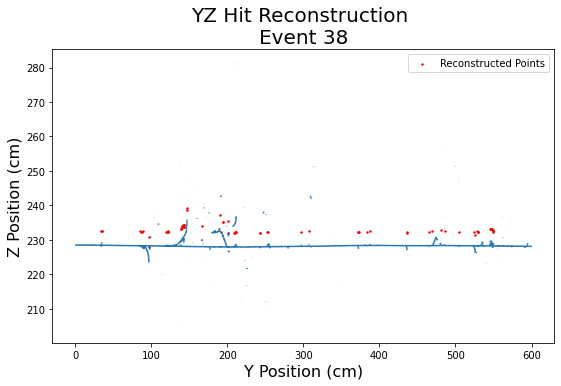

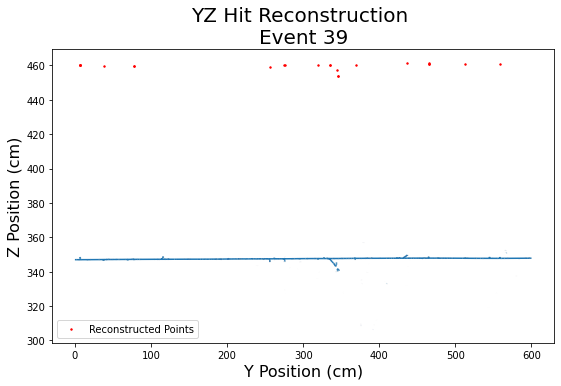

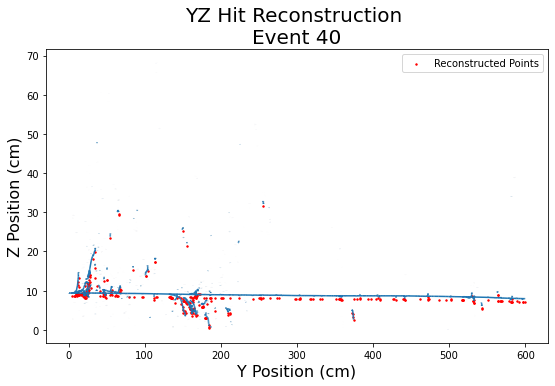

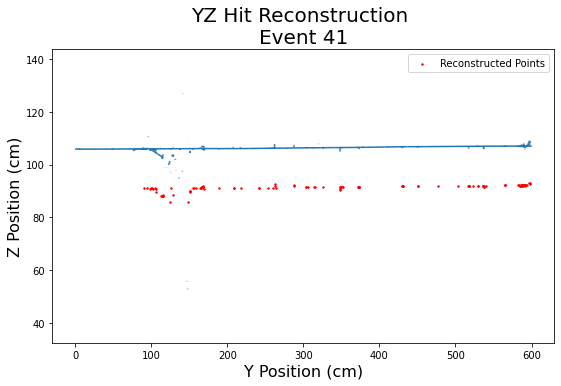

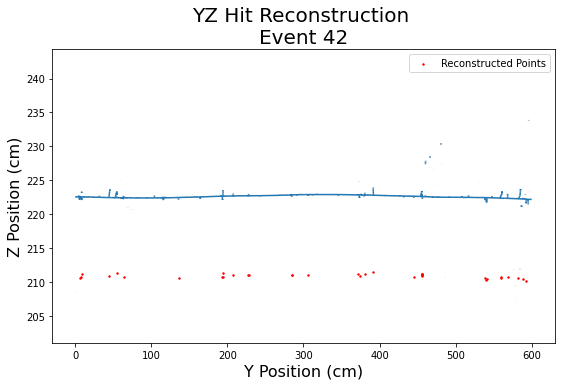

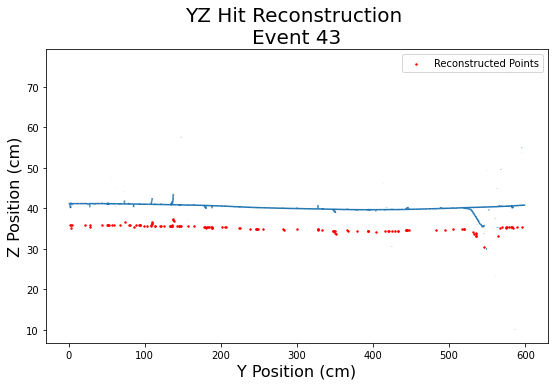

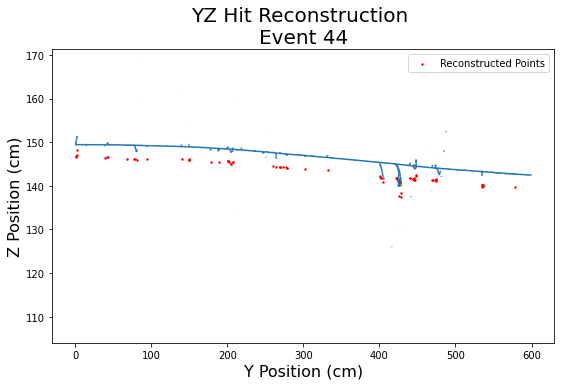

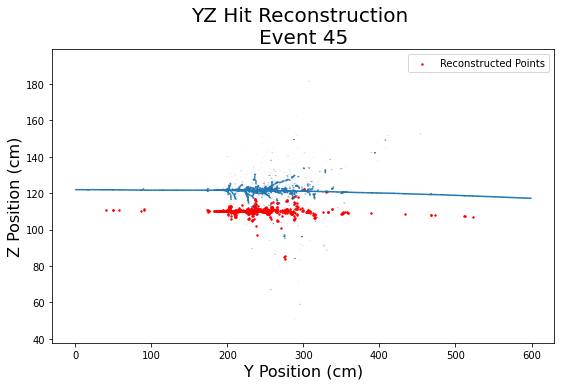

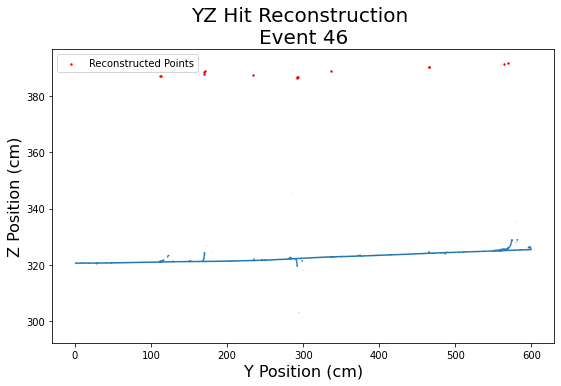

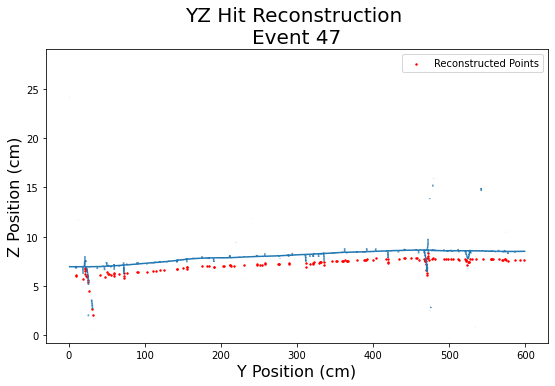

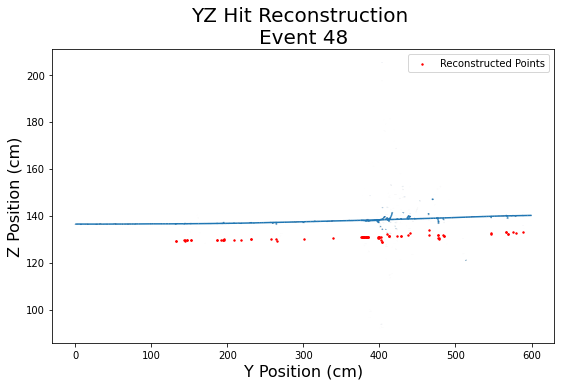

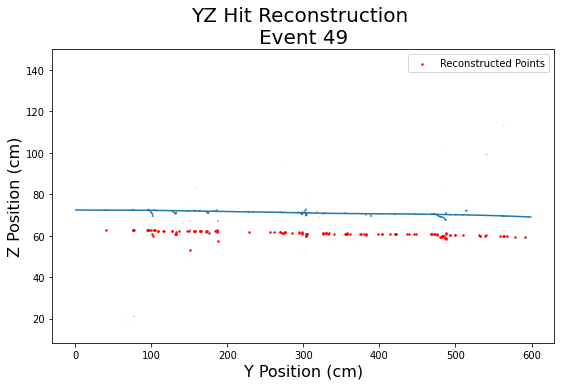

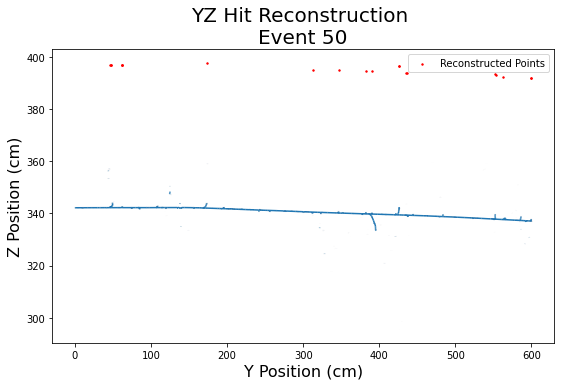

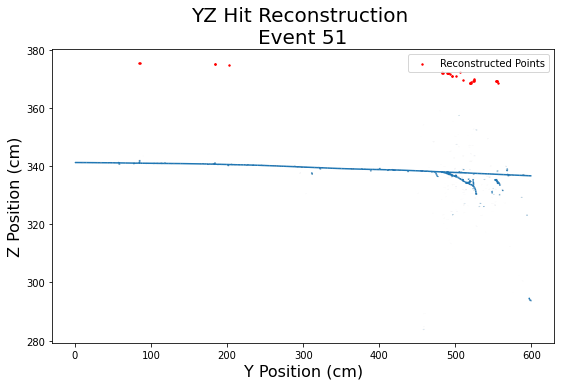

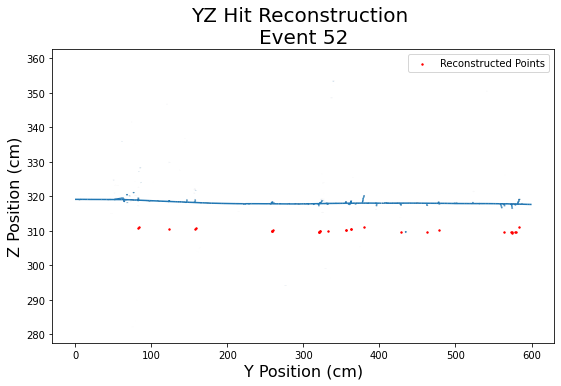

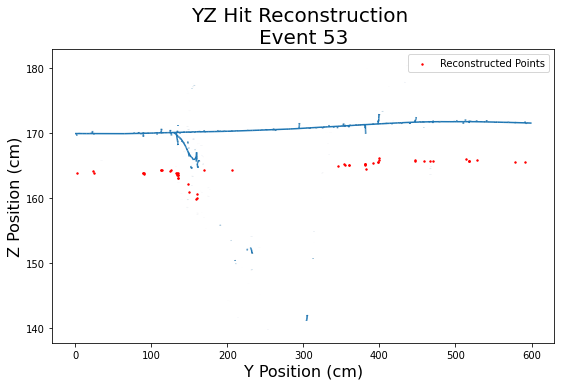

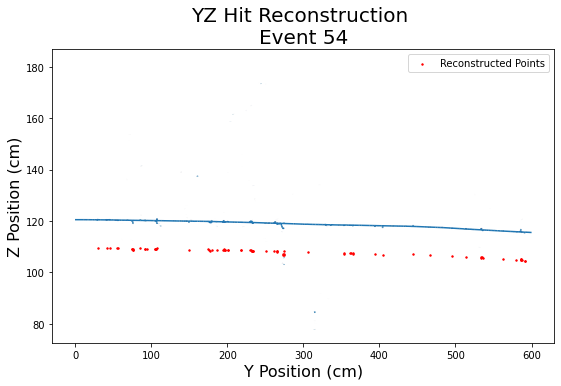

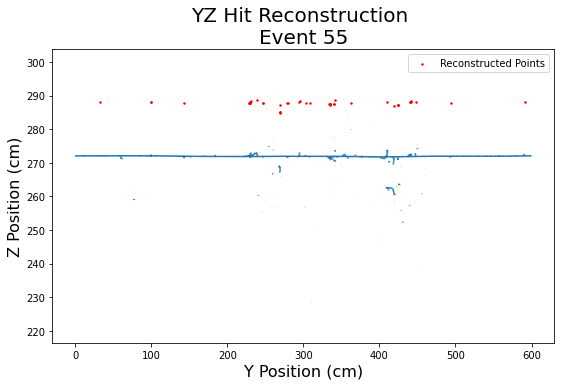

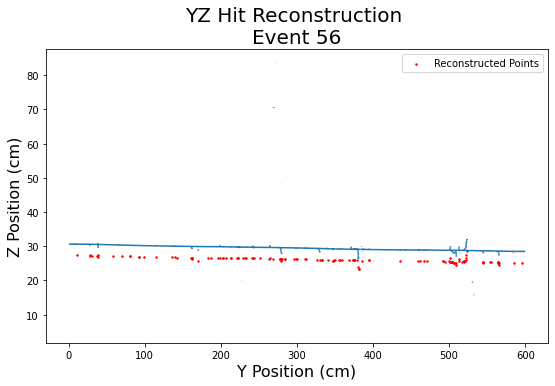

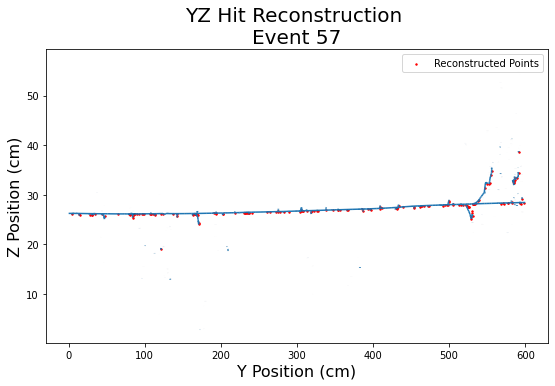

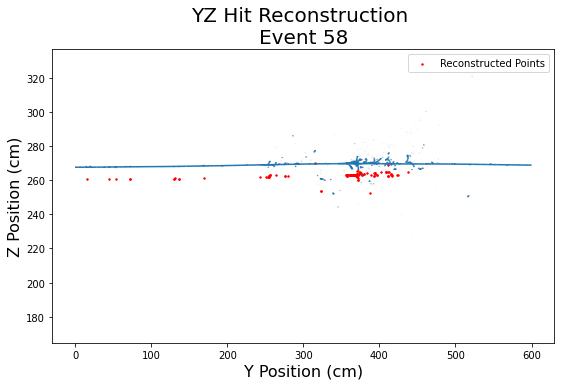

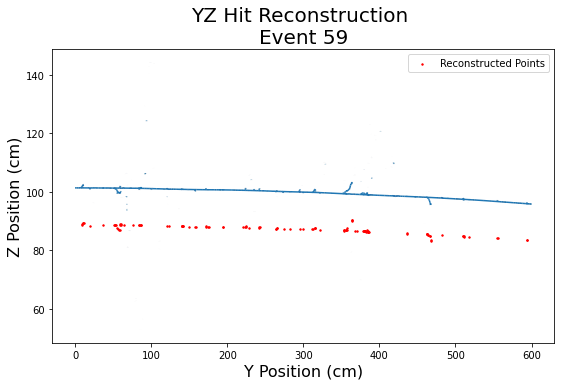

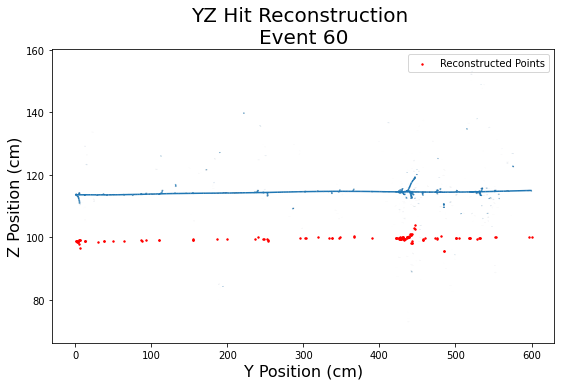

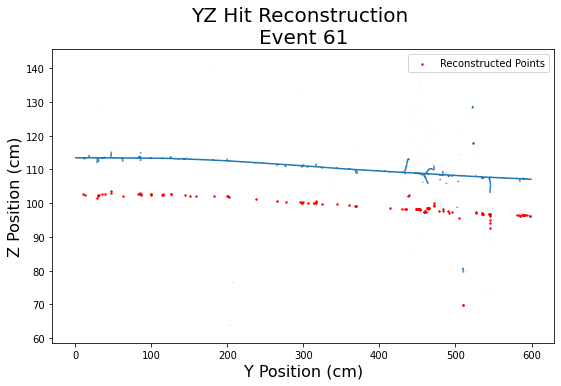

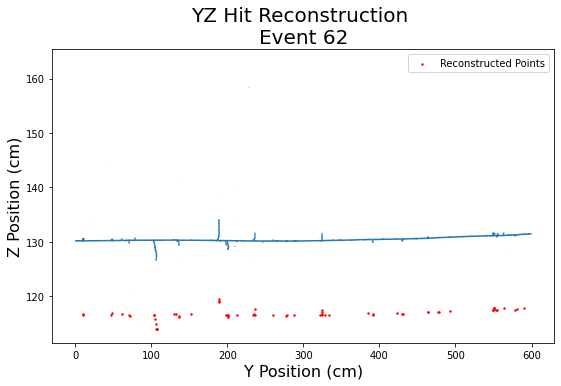

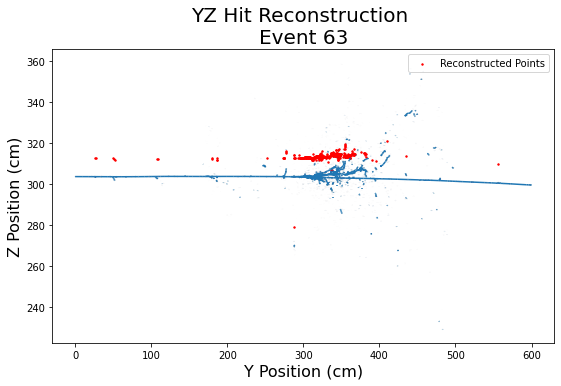

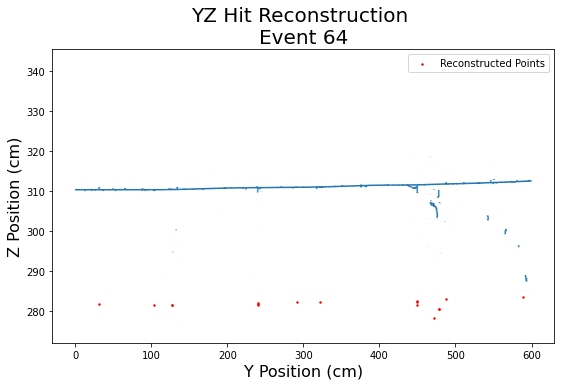

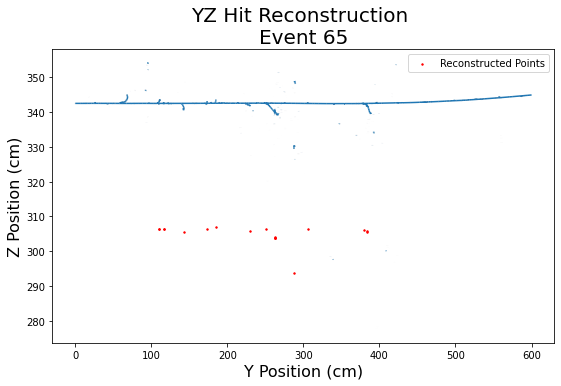

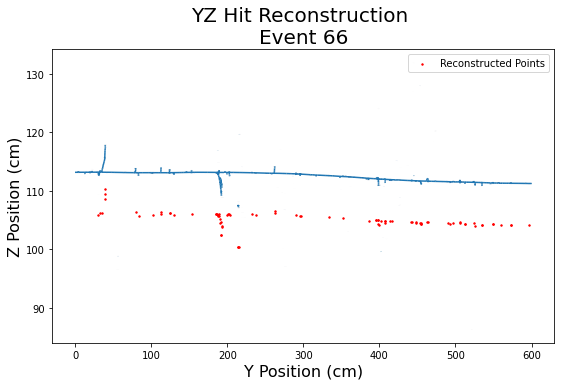

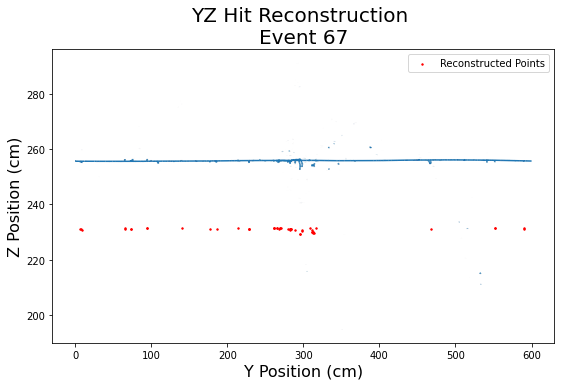

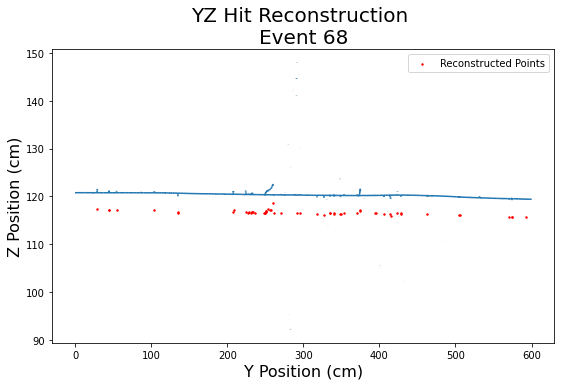

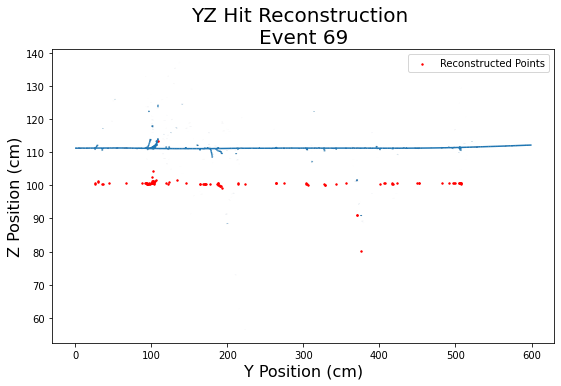

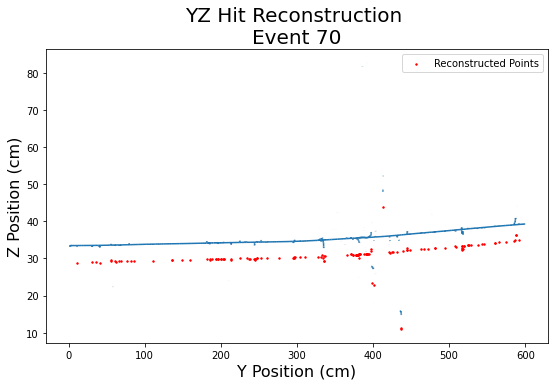

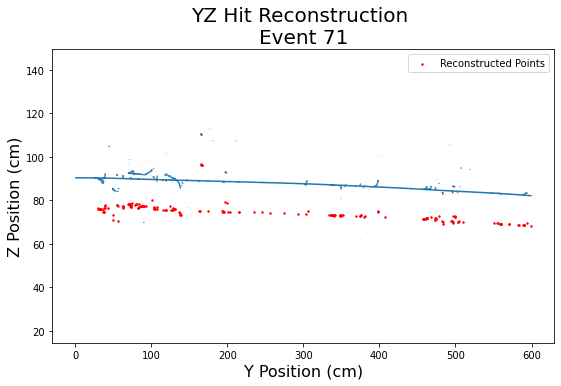

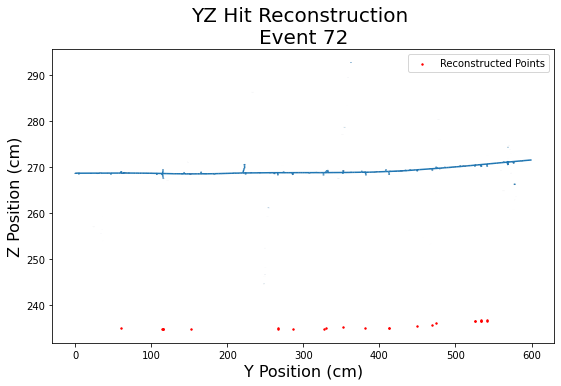

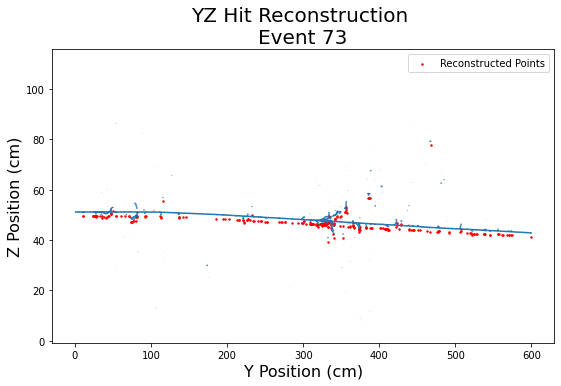

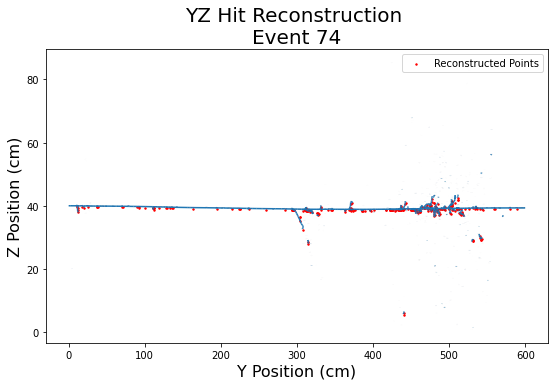

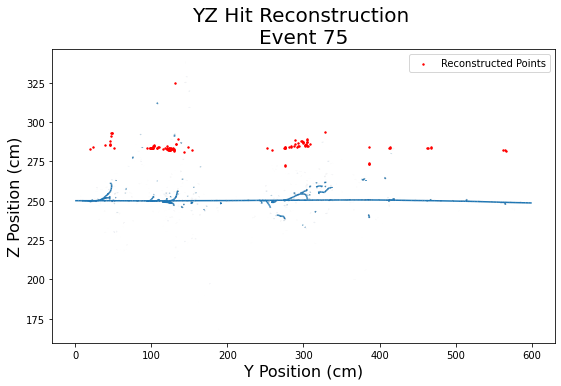

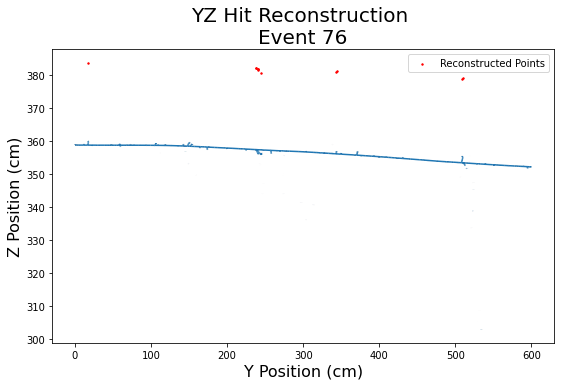

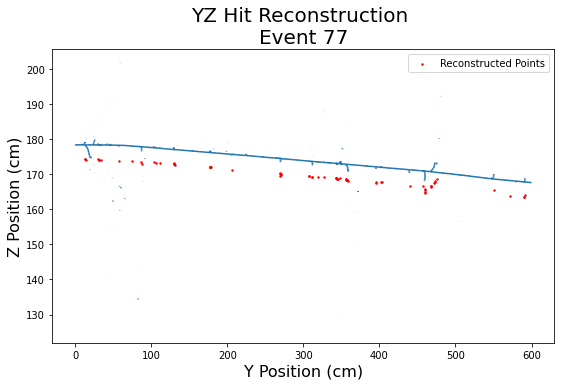

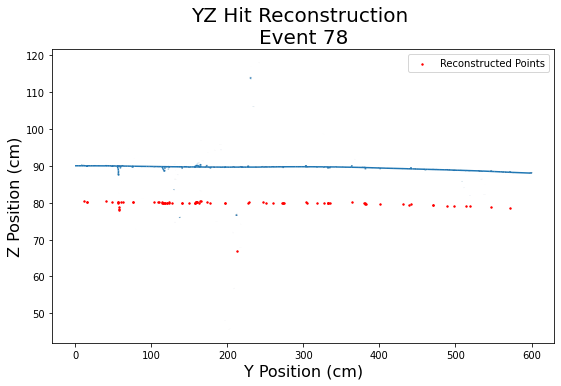

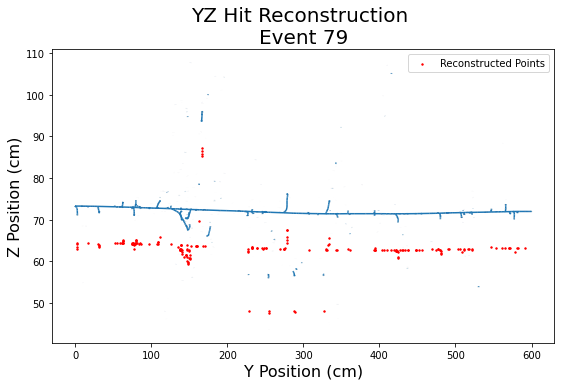

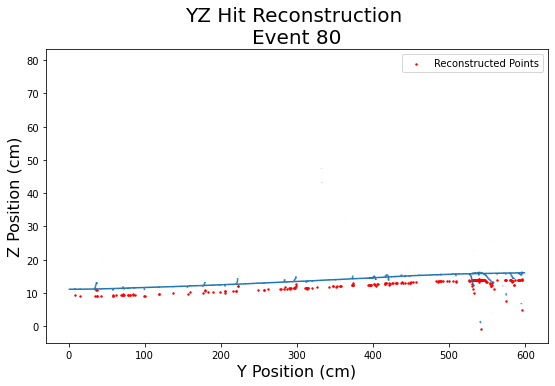

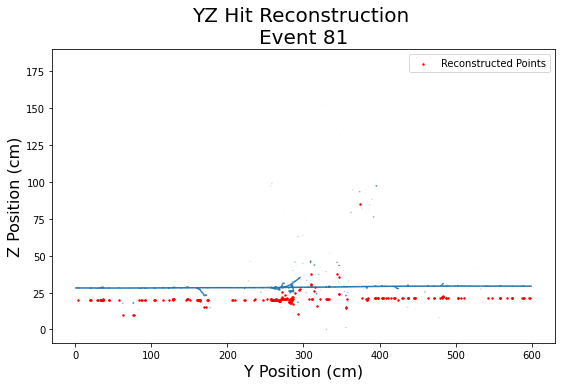

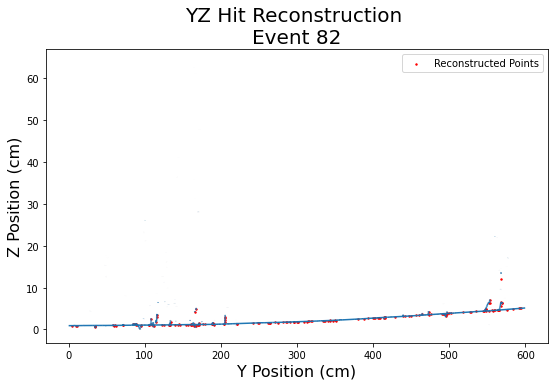

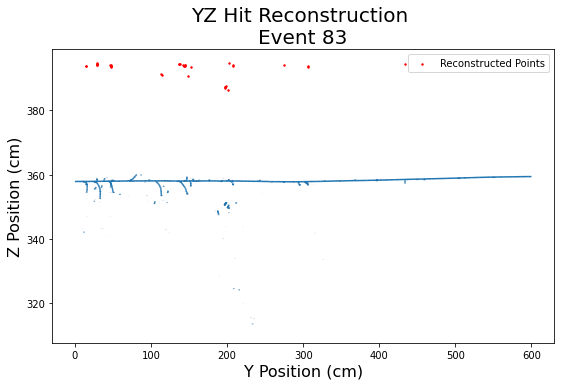

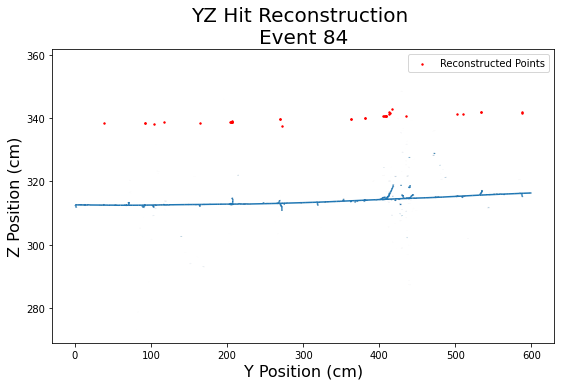

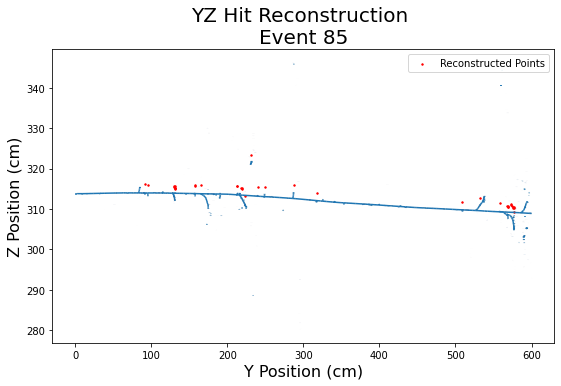

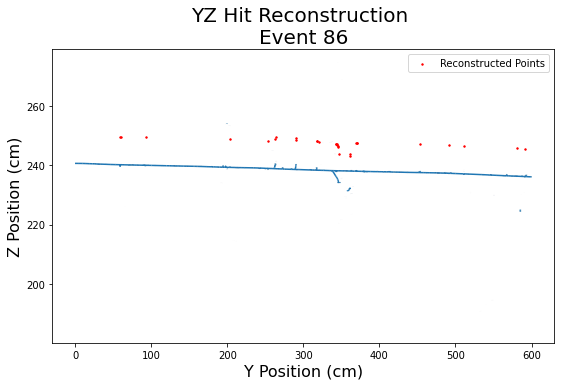

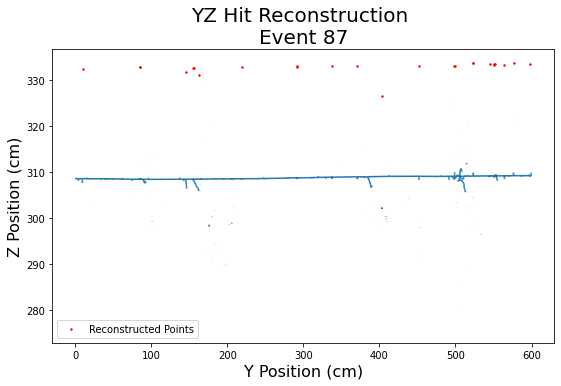

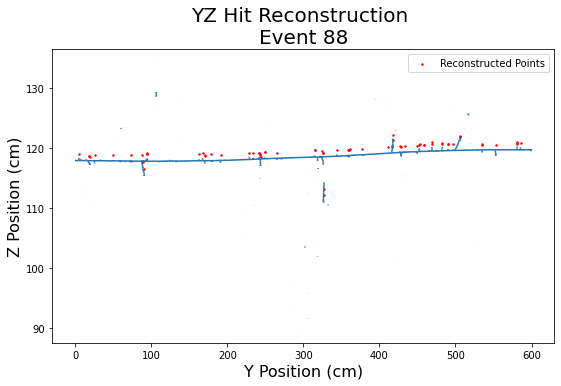

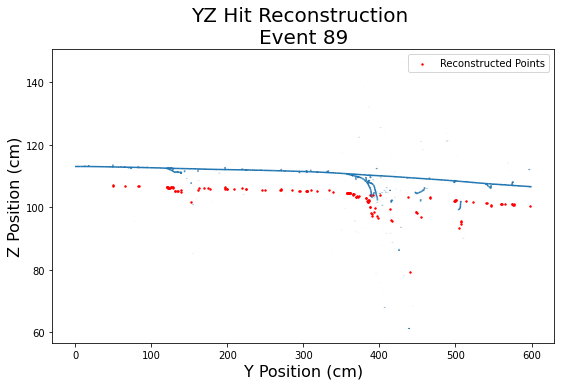

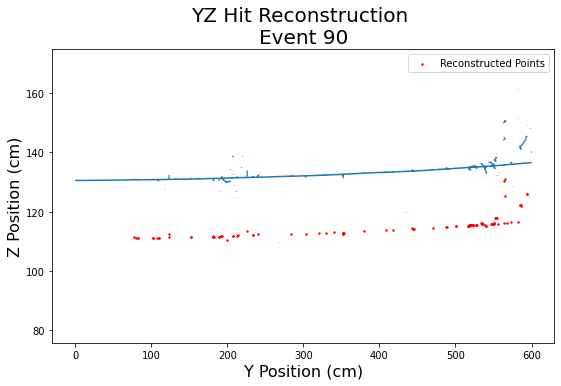

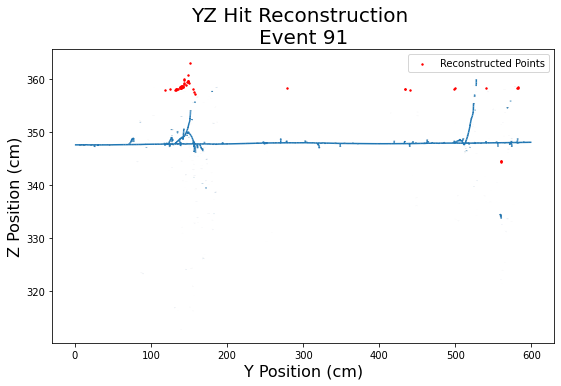

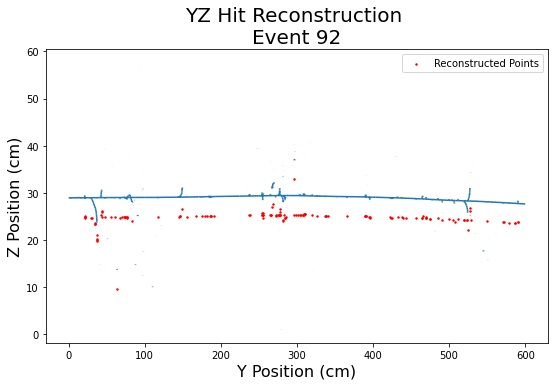

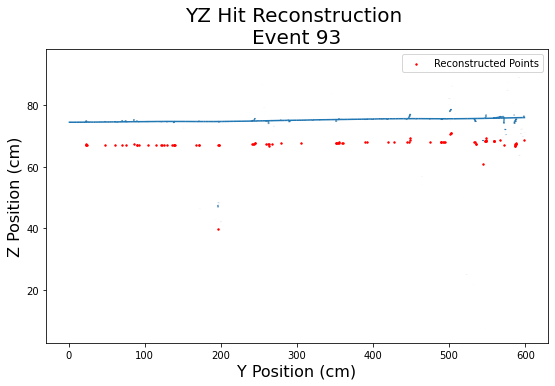

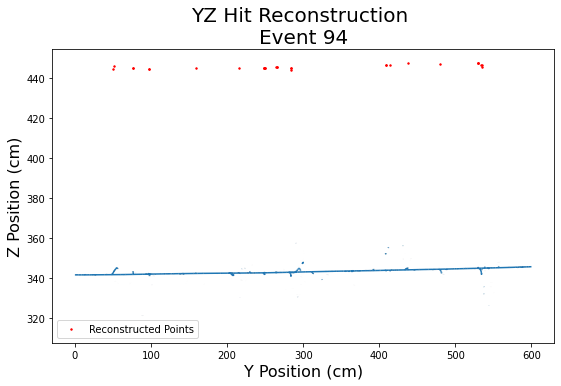

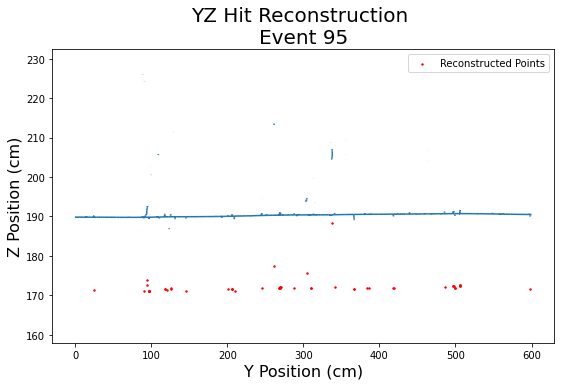

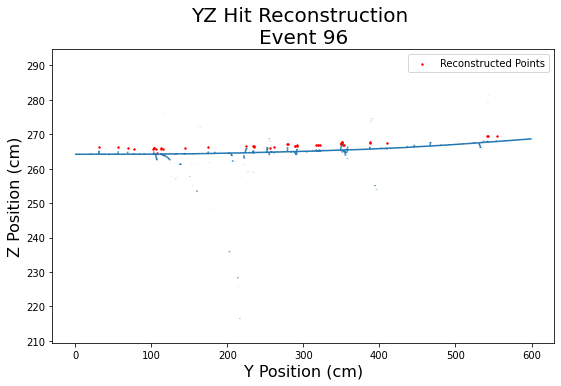

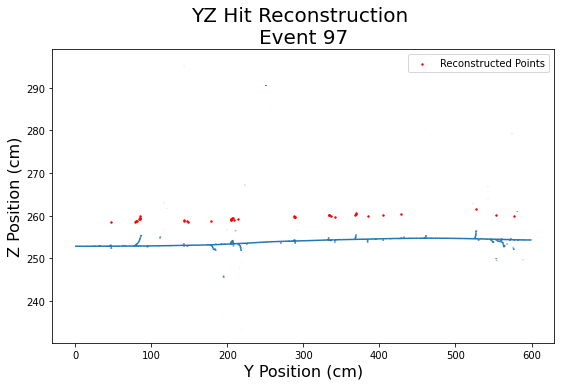

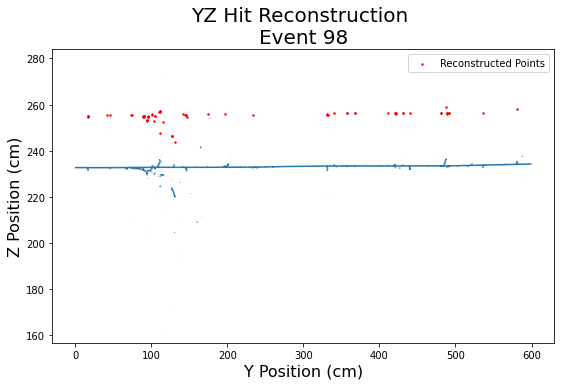

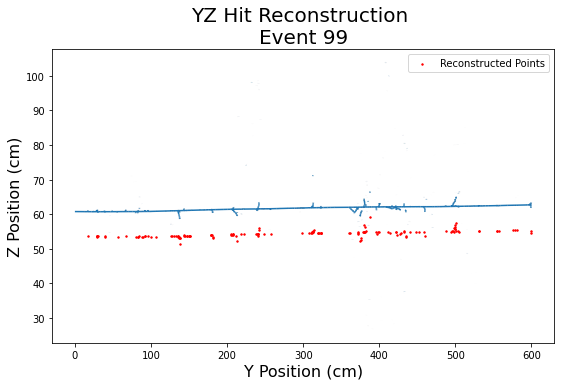

In [134]:
# Plot the YZ data for event = EVENT_NUM

for n in range(total_events):
    # Changes datafram ecolumns to arrays
    yi = pd.DataFrame(data = {"yi" : g4_df[g4_df["event"] == n]["yi"]}).to_numpy()
    zi = pd.DataFrame(data = {"zi" : g4_df[g4_df["event"] == n]["zi"]}).to_numpy()
    yf = pd.DataFrame(data = {"yf" : g4_df[g4_df["event"] == n]["yf"]}).to_numpy()
    zf = pd.DataFrame(data = {"zf" : g4_df[g4_df["event"] == n]["zf"]}).to_numpy()

    # Combines the 1D arrays to one 2D array
    initials = np.column_stack((yi, zi))
    finals = np.column_stack((yf, zf))

    # Combine to two arrays to one array with row = [[yi, zi], [yf, zf]]
    combined = np.zeros((len(initials), 2, 2))
    combined[:, 0] = initials
    combined[:, 1] = finals

    # Plot all the G4 data overlayed with the reconstruction data for all events:
    # Create the plot
    fig, ax = plt.subplots()
    fig.set_figheight(5.4)
    fig.set_figwidth(9)

    # Label the axes for the plot
    ax.set_title('YZ Hit Reconstruction \nEvent %d' %n, fontsize=20)
    ax.set_xlabel('Y Position (cm)', fontsize=16)
    ax.set_ylabel('Z Position (cm)', fontsize=16)
    
    
    # Plot the G4 data via Line Collections
    line_segments = LineCollection(combined)
    ax.add_collection(line_segments)
    ax.autoscale()
    
    
    # Plot the points from the t0 values
    # Divide by 10 to convert from mm to cm (G4 is in cm)
    ax.scatter(reconstruction_df.Y_Position[(reconstruction_df.event == n)]/10, 
                reconstruction_df.Z_Position[(reconstruction_df.event == n)]/10, s = 2, color = 'red', 
                label = 'Reconstructed Points')

    plt.legend()
    plt.show()
    plt.close()